# Converting audio to csv

In [84]:
import os
import csv

# Define the paths to the folders
folders = {
    'Brown_Tinamou': "E:\\AIML\\Audio Classifier\\Audio\\folder1",
    'Cinereous_Tinamou': 'E:\\AIML\\Audio Classifier\\Audio\\folder2',
    'Great_Tinamou': 'E:\\AIML\\Audio Classifier\\Audio\\folder3'
}

# Define class ids for each class
class_ids = {
    'Brown_Tinamou': 1,
    'Cinereous_Tinamou': 2,
    'Great_Tinamou': 3
}

# Define folder ids for each class
folder_ids = {
    'Brown_Tinamou': 1,
    'Cinereous_Tinamou': 2,
    'Great_Tinamou': 3
}

# List to hold the data
data = []

# Loop through each folder and retrieve the files
for class_name, folder_path in folders.items():
    class_id = class_ids[class_name]
    folder_id = folder_ids[class_name]
    for filename in os.listdir(folder_path):
        # Check if the file is an audio file based on its extension
        if filename.lower().endswith(('.wav', '.mp3')):  # Adjust based on your file types
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                data.append([filename, folder_id, class_id, class_name])

# Define the output directory and create it if it doesn't exist
output_dir = 'Audio_samples'
os.makedirs(output_dir, exist_ok=True)

# Define the CSV file path
csv_file_path = os.path.join(output_dir, 'audio_samples.csv')

# Write the data to the CSV file
with open(csv_file_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['file_name', 'folder', 'class_id', 'class'])
    writer.writerows(data)

print(f"CSV file '{csv_file_path}' created successfully.")

CSV file 'Audio_samples\audio_samples.csv' created successfully.


# EDA

In [85]:
!pip install librosa


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display

In [87]:
filename = "E:\\AIML\\Audio Classifier\\Audio\\folder1\\XC176295 - Brown Tinamou - Crypturellus obsoletus.mp3"

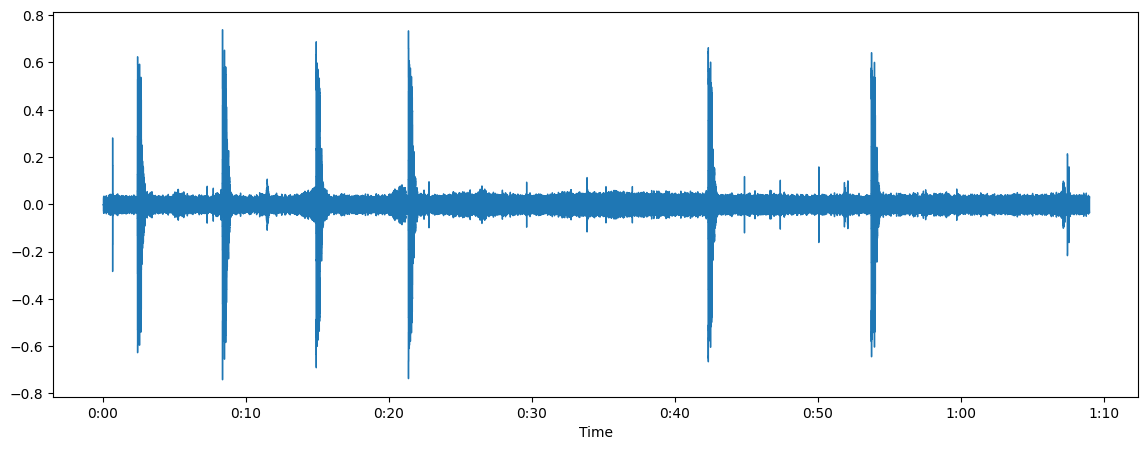

In [88]:
plt.figure(figsize=(14,5))
data,sample_rate = librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

In [89]:
data

array([ 7.5669959e-10, -3.4924597e-10, -2.3283064e-10, ...,
       -5.8481465e-03, -1.1278594e-02, -1.5192235e-02], dtype=float32)

In [90]:
sample_rate

22050

In [91]:
import numpy as np
import pandas as pd

In [92]:
metadata = pd.read_csv("E:/AIML/Audio Classifier/Audio_samples/audio_samples.csv")
metadata.head()

,file_name,folder,class_id,class
0,XC115082 - Brown Tinamou - Crypturellus obsole...,1,1,Brown_Tinamou
1,XC115085 - Brown Tinamou - Crypturellus obsole...,1,1,Brown_Tinamou
2,XC145686 - Brown Tinamou - Crypturellus obsole...,1,1,Brown_Tinamou
3,XC164486 - Brown Tinamou - Crypturellus obsole...,1,1,Brown_Tinamou
4,XC171118 - Brown Tinamou - Crypturellus obsole...,1,1,Brown_Tinamou


In [93]:
metadata['class'].value_counts() #checking if dataset is imbalanced

class
Brown_Tinamou        50
Cinereous_Tinamou    50
Great_Tinamou        50
Name: count, dtype: int64

# feature extraction & data augmentation

In [94]:
audio_dataset_path = "E:/AIML/Audio Classifier/Audio"

In [95]:
!pip install resampy


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [96]:
!pip install --upgrade librosa


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
#extracting mfcc for every audio
import numpy as np
import librosa

def feature_extractor(file):
    audio, sample_rate = librosa.load(file_name,res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

#data augmentation
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_stretch(audio):
    return librosa.effects.time_stretch(audio, rate=1.25)

def pitch_shift(audio):
    return librosa.effects.pitch_shift(audio,sr=sample_rate,n_steps=2)

In [106]:
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'folder'+str(row["folder"])+'/',str(row["file_name"]))
    final_class_labels=row["class"]
    data=feature_extractor(file_name)
    extracted_features.append([data,final_class_labels])
    
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    augmented_audio = add_noise(audio)
    data = feature_extractor(augmented_audio)
    extracted_features.append([data, final_class_labels])
    
    augmented_audio = time_stretch(audio)
    data = feature_extractor(augmented_audio)
    extracted_features.append([data, final_class_labels])
    
    augmented_audio = pitch_shift(audio)
    data = feature_extractor(augmented_audio)
    extracted_features.append([data, final_class_labels])

150it [08:19,  3.33s/it]


In [107]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-319.55374, 51.38316, -60.324688, 22.672245, ...",Brown_Tinamou
1,"[-319.55374, 51.38316, -60.324688, 22.672245, ...",Brown_Tinamou
2,"[-319.55374, 51.38316, -60.324688, 22.672245, ...",Brown_Tinamou
3,"[-319.55374, 51.38316, -60.324688, 22.672245, ...",Brown_Tinamou
4,"[-256.45038, -6.2839684, -81.26912, 33.423347,...",Brown_Tinamou


# splitting data

In [108]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [109]:
X.shape

(600, 40)

In [110]:
y.shape

(600,)

In [111]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
lblencoder = LabelEncoder()
y = to_categorical(lblencoder.fit_transform(y))

In [112]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [113]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [114]:
X_train.shape

(420, 40)

In [115]:
X_test.shape

(180, 40)

# Model Creation

In [162]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn import metrics

In [163]:
num_labels = y.shape[1]

In [164]:
num_labels

3

In [165]:
model = Sequential()
#layer1
model.add(Dense(64,input_shape=(40,),kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.6))
#layer2
model.add(Dense(128, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.6))
#final
model.add(Dense(num_labels))
model.add(Activation('softmax'))

C:\Users\TUF_Gaming\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [166]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 3)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,331 (44.26 KB)

 Trainable params: 11,331 (44.26 KB)

 Non-trainable params: 0 (0.00 B)

In [167]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [168]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='E:\\AIML\\Audio Classifier\\audioclassify3.keras',
                               verbose=1,save_best_only=True)
start = datetime.now()
model.fit(X_train,y_train,batch_size=num_batch_size,epochs=num_epochs,validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("training completion",duration)

Epoch 1/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4062 - loss: 38.3215
Epoch 1: val_loss improved from inf to 9.33058, saving model to E:\AIML\Audio Classifier\audioclassify3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3875 - loss: 49.8674 - val_accuracy: 0.4833 - val_loss: 9.3306
Epoch 2/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4062 - loss: 45.9357
Epoch 2: val_loss improved from 9.33058 to 7.88439, saving model to E:\AIML\Audio Classifier\audioclassify3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3897 - loss: 44.4304 - val_accuracy: 0.3778 - val_loss: 7.8844
Epoch 3/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.2812 - loss: 51.5344
Epoch 3: val_loss improved from 7.88439 to 6.75225, saving model to E:\AIML\Audio Classifier\audioclassify3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3218 - loss: 43.9396 - val_accuracy: 0.4611 - val_loss: 6.7523
Epoch 4/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step -

Epoch 24/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5312 - loss: 2.8438
Epoch 24: val_loss did not improve from 1.48327
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5393 - loss: 4.0244 - val_accuracy: 0.7333 - val_loss: 1.5417
Epoch 25/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6562 - loss: 3.6070
Epoch 25: val_loss did not improve from 1.48327
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5697 - loss: 3.4414 - val_accuracy: 0.7167 - val_loss: 1.5532
Epoch 26/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4688 - loss: 3.8555
Epoch 26: val_loss did not improve from 1.48327
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5176 - loss: 3.8919 - val_accuracy: 0.7556 - val_loss: 1.5428
Epoch 27/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5312 - loss: 3.7186
Epoch 27: val_loss did not improve from 1.48327
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5718 - loss: 3.3339 - val_accuracy: 0.7944 - val_loss: 1.5464

Epoch 50/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6250 - loss: 2.1130
Epoch 50: val_loss did not improve from 1.48327
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6378 - loss: 1.9289 - val_accuracy: 0.8667 - val_loss: 1.5136
Epoch 51/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6875 - loss: 1.5328
Epoch 51: val_loss did not improve from 1.48327
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6499 - loss: 1.6817 - val_accuracy: 0.8444 - val_loss: 1.4996
Epoch 52/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.3750 - loss: 2.3067
Epoch 52: val_loss did not improve from 1.48327
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5616 - loss: 1.9729 - val_accuracy: 0.8889 - val_loss: 1.4926
Epoch 53/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5625 - loss: 2.1250
Epoch 53: val_loss improved from 1.48327 to 1.47233, saving model to E:\AIML\Audio Classifier\audioclassify3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accurac

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7118 - loss: 1.4980 - val_accuracy: 0.9444 - val_loss: 1.2334
Epoch 73/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7188 - loss: 1.4173
Epoch 73: val_loss improved from 1.23343 to 1.21532, saving model to E:\AIML\Audio Classifier\audioclassify3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7290 - loss: 1.4321 - val_accuracy: 0.9389 - val_loss: 1.2153
Epoch 74/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7188 - loss: 1.4964
Epoch 74: val_loss improved from 1.21532 to 1.19426, saving model to E:\AIML\Audio Classifier\audioclassify3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7257 - loss: 1.4417 - val_accuracy: 0.9444 - val_loss: 1.1943
Epoch 75/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8438 - loss: 1.2223
Epoch 75: val_loss improved from 1.19426 to 1.17969, saving model to E:\AIML\Audio Classifier\audioclassify3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy

Epoch 94/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7500 - loss: 1.4026
Epoch 94: val_loss improved from 1.02781 to 1.01289, saving model to E:\AIML\Audio Classifier\audioclassify3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7607 - loss: 1.2728 - val_accuracy: 0.9500 - val_loss: 1.0129
Epoch 95/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7812 - loss: 1.1251
Epoch 95: val_loss improved from 1.01289 to 0.99295, saving model to E:\AIML\Audio Classifier\audioclassify3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8001 - loss: 1.1658 - val_accuracy: 0.9611 - val_loss: 0.9929
Epoch 96/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8438 - loss: 1.1069
Epoch 96: val_loss improved from 0.99295 to 0.98582, saving model to E:\AIML\Audio Classifier\audioclassify3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8268 - loss: 1.2022 - val_accuracy: 0.9556 - val_loss: 0.9858
Epoch 97/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/

# Predictions and accuracy

In [169]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9777777791023254


In [170]:
train_accuracy=model.evaluate(X_train,y_train,verbose=0)
print(train_accuracy[1])

0.9809523820877075


In [171]:
X_test[1]

array([-6.3592139e+02,  7.4891953e+01, -1.1745803e+01,  4.0019718e+01,
        3.4258523e+00,  2.2307762e+01, -6.8620858e+00,  1.9802294e+01,
        4.3091888e+00,  1.0840132e+01,  2.8719761e+00,  1.4023354e+01,
        1.9581180e+00,  5.9088407e+00,  2.2601631e+00,  6.9133863e+00,
        2.5614409e+00,  3.0642917e+00,  3.9516141e+00,  3.5698740e+00,
        2.3172472e+00,  3.3495600e+00,  4.6740603e+00,  7.8331983e-01,
        1.2526786e+00,  3.4205890e+00,  4.3034930e+00, -1.0989785e+00,
        1.9439708e+00,  2.2766969e+00,  2.6597235e+00, -2.3456928e-01,
        2.4188240e+00,  3.8827339e-01,  2.0393844e+00,  4.6504867e-01,
        2.2393348e+00,  2.0900144e-01,  1.3190697e+00,  1.5940444e+00],
      dtype=float32)

In [172]:
import numpy as np
predictions = model.predict(X_test)
class_labels = np.argmax(predictions, axis=1)
class_labels = lblencoder.inverse_transform(class_labels)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [173]:
class_labels

array(['Great_Tinamou', 'Brown_Tinamou', 'Cinereous_Tinamou',
       'Great_Tinamou', 'Cinereous_Tinamou', 'Great_Tinamou',
       'Great_Tinamou', 'Great_Tinamou', 'Great_Tinamou', 'Brown_Tinamou',
       'Cinereous_Tinamou', 'Great_Tinamou', 'Brown_Tinamou',
       'Cinereous_Tinamou', 'Brown_Tinamou', 'Great_Tinamou',
       'Great_Tinamou', 'Brown_Tinamou', 'Brown_Tinamou',
       'Cinereous_Tinamou', 'Great_Tinamou', 'Great_Tinamou',
       'Cinereous_Tinamou', 'Brown_Tinamou', 'Great_Tinamou',
       'Brown_Tinamou', 'Cinereous_Tinamou', 'Great_Tinamou',
       'Great_Tinamou', 'Great_Tinamou', 'Cinereous_Tinamou',
       'Great_Tinamou', 'Cinereous_Tinamou', 'Brown_Tinamou',
       'Brown_Tinamou', 'Great_Tinamou', 'Brown_Tinamou',
       'Cinereous_Tinamou', 'Cinereous_Tinamou', 'Brown_Tinamou',
       'Cinereous_Tinamou', 'Cinereous_Tinamou', 'Cinereous_Tinamou',
       'Brown_Tinamou', 'Cinereous_Tinamou', 'Brown_Tinamou',
       'Cinereous_Tinamou', 'Brown_Tinamou', 'Great_T

In [174]:
accuracyy= model.evaluate(X_test,predictions,verbose=0)
print(accuracyy[1])

1.0


# testing for new data

In [212]:
Test_filename = "E:\\AIML\\Audio Classifier\\XC157392 - Brown Tinamou - Crypturellus obsoletus.mp3"
Test_filename

'E:\\AIML\\Audio Classifier\\XC157392 - Brown Tinamou - Crypturellus obsoletus.mp3'

In [213]:
def get_mfcc(Test_filename):
    audio, sample_rate = librosa.load(Test_filename, res_type='kaiser_fast') 
    mfcc_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfcc_scaled_features = np.mean(mfcc_features.T,axis=0)
    mfcc_scaled_features=mfcc_scaled_features.reshape(1,-1)
    return mfcc_scaled_features

In [214]:
predictions = model.predict(get_mfcc(Test_filename))

def preds(predictions):
    pred_class_labels = np.argmax(predictions, axis=1)
    pred_class_labels = lblencoder.inverse_transform(pred_class_labels)
    print(pred_class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [215]:
preds(predictions)

['Brown_Tinamou']


# Pickling model

In [204]:
from keras.models import load_model
model.save('DLmodel.h5')

In [205]:
pickle_model = load_model('DLmodel.h5')

In [216]:
pred=pickle_model.predict(get_mfcc("E:\\AIML\\Audio Classifier\\XC157392 - Brown Tinamou - Crypturellus obsoletus.mp3"))
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.903388  , 0.05841944, 0.03819253]], dtype=float32)

In [217]:
preds(pred)

['Brown_Tinamou']
